In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Use correct DB path from Google Drive
db_path = "/content/drive/MyDrive/capstone-data/energy_timeseries.db"
conn = sqlite3.connect(db_path)


df = pd.read_sql_query("SELECT * FROM timeseries_energy_weather", conn, parse_dates=['datetime'])
df.set_index('datetime', inplace=True)
df.head()


,global_active_power,voltage,sub_metering_1,sub_metering_2,sub_metering_3,temp,humidity,windspeed,cloudcover
datetime,,,,,,,,,
2007-01-01 00:00:00,2.550633,241.361333,0.0,0.583333,0.0,13.9,86.47,30.9,95.5
2007-01-01 01:00:00,2.523400,241.096500,0.0,0.000000,0.0,14.0,85.10,25.5,96.9
2007-01-01 02:00:00,2.582333,243.200167,0.0,0.333333,0.0,14.0,84.29,27.7,92.7
2007-01-01 03:00:00,2.541667,243.265667,0.0,0.266667,0.0,13.8,80.82,21.7,67.7
2007-01-01 04:00:00,2.475733,242.456167,0.0,0.000000,0.0,12.9,59.76,26.8,23.7


**Aggregate consumption**

Daily aggregated consumption (first 5 rows):
            global_active_power
datetime                       
2007-01-01             1.888768
2007-01-02             0.879929
2007-01-03             0.691147
2007-01-04             1.997993
2007-01-05             1.792539

 Hourly average consumption across all days:
      global_active_power
hour                     
0                0.679903
1                0.544566
2                0.481998
3                0.449531
4                0.446597
5                0.460494
6                0.747270
7                1.427345
8                1.438579
9                1.228605
10               1.120065
11               1.072903
12               1.019553
13               0.987041
14               0.992767
15               0.938556
16               0.918236
17               1.047927
18               1.332105
19               1.709741
20               1.800674
21               1.862576
22               1.429103
23               0.935064


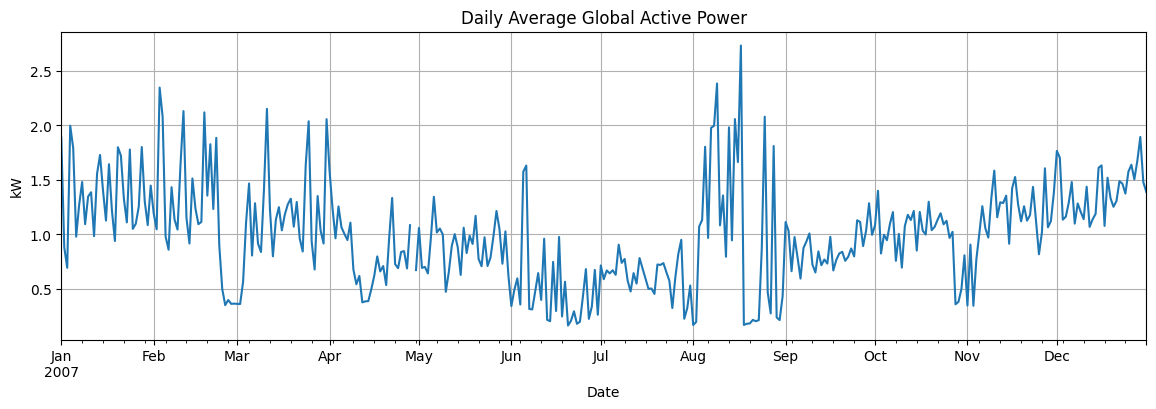

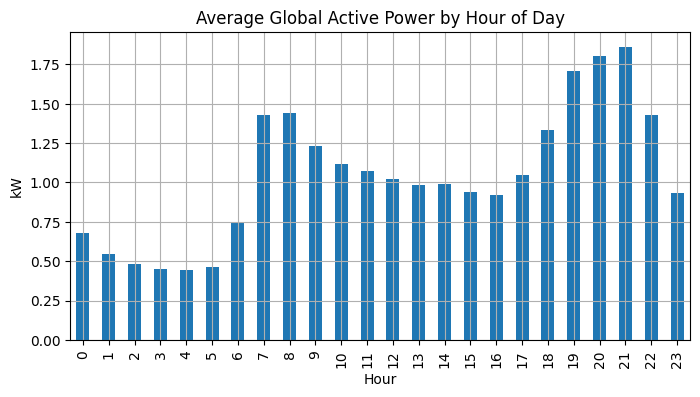

In [4]:
# Daily average
df_daily = df.resample('D').mean()
print("Daily aggregated consumption (first 5 rows):")
print(df_daily[['global_active_power']].head())

# Hourly average across all days
df['hour'] = df.index.hour
df_hourly_avg = df.groupby('hour').mean()
print("\n Hourly average consumption across all days:")
print(df_hourly_avg[['global_active_power']])

# Visualize daily consumption
plt.figure(figsize=(14, 4))
df_daily['global_active_power'].plot()
plt.title("Daily Average Global Active Power")
plt.ylabel("kW")
plt.xlabel("Date")
plt.grid(True)
plt.show()

# Visualize hourly average consumption
plt.figure(figsize=(8, 4))
df_hourly_avg['global_active_power'].plot(kind='bar')
plt.title("Average Global Active Power by Hour of Day")
plt.ylabel("kW")
plt.xlabel("Hour")
plt.grid(True)
plt.show()

**Compute peak load statistics**


 Peak load: 3.45 kW at 2007-01-21 19:00:00

 Daily peak load (first 5 days):
datetime
2007-01-01    2.786867
2007-01-02    2.537897
2007-01-03    1.485544
2007-01-04    2.944571
2007-01-05    2.518615
Freq: D, Name: global_active_power, dtype: float64


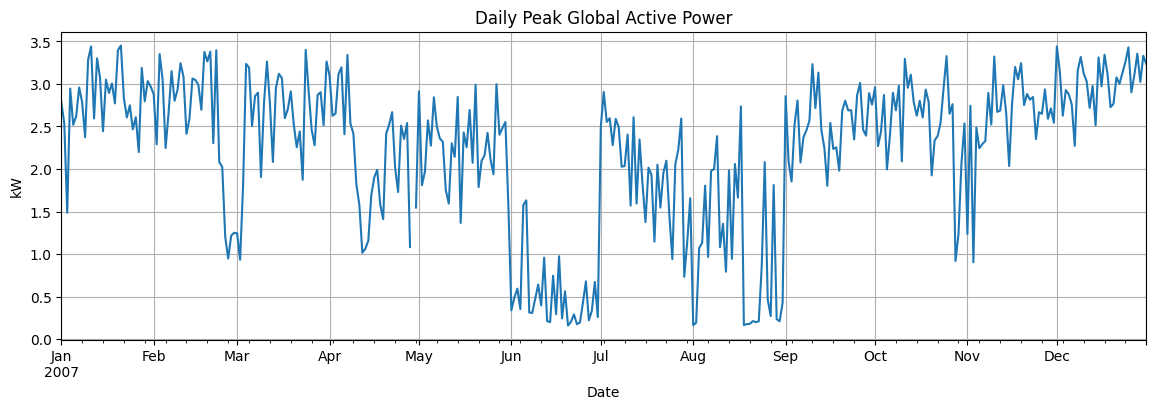

In [5]:
peak_power = df['global_active_power'].max()
peak_time = df['global_active_power'].idxmax()
print(f"\n Peak load: {peak_power:.2f} kW at {peak_time}")

# Daily peak load
daily_peak = df.resample('D')['global_active_power'].max()
print("\n Daily peak load (first 5 days):")
print(daily_peak.head())

# Visualize daily peak load
plt.figure(figsize=(14, 4))
daily_peak.plot()
plt.title("Daily Peak Global Active Power")
plt.ylabel("kW")
plt.xlabel("Date")
plt.grid(True)
plt.show()

**Correlate energy use with weather**


 Correlation matrix:
                     global_active_power      temp  humidity  windspeed  \
global_active_power             1.000000 -0.196464  0.052416   0.049079   
temp                           -0.196464  1.000000 -0.503176   0.044554   
humidity                        0.052416 -0.503176  1.000000  -0.109412   
windspeed                       0.049079  0.044554 -0.109412   1.000000   
cloudcover                      0.050619  0.028269  0.294793   0.296079   

                     cloudcover  
global_active_power    0.050619  
temp                   0.028269  
humidity               0.294793  
windspeed              0.296079  
cloudcover             1.000000  


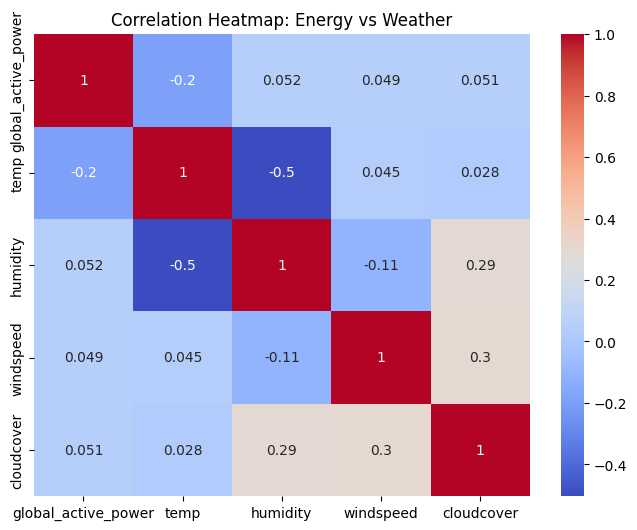

In [6]:
corr_matrix = df[['global_active_power', 'temp', 'humidity', 'windspeed', 'cloudcover']].corr()
print("\n Correlation matrix:")
print(corr_matrix)

# Visualize correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap: Energy vs Weather")
plt.show()



*   Main factor affecting consumption: Temperature (negative, small).
*   Other weather factors: Humidity, wind, and cloudcover have almost no impact on consumption.
*   Practical interpretation: In 2007 Paris, electricity use was slightly higher on colder days (likely due to heating).












**Index or partition for faster queries**

In [7]:
conn.execute("CREATE INDEX IF NOT EXISTS idx_datetime ON timeseries_energy_weather(datetime);")
conn.commit()
print("\n Index created on datetime column in SQLite database.")



 Index created on datetime column in SQLite database.


**feature tables**

In [8]:
# Daily feature table
feature_table_daily = df.resample('D').agg({
    'global_active_power': ['mean', 'max', 'min'],
    'temp': 'mean',
    'humidity': 'mean'
})
feature_table_daily.columns = ['_'.join(col) for col in feature_table_daily.columns]

# Hourly feature table
feature_table_hourly = df.groupby('hour').agg({
    'global_active_power': 'mean',
    'temp': 'mean',
    'humidity': 'mean'
})

# Save to CSV
feature_table_daily.to_csv('/content/drive/MyDrive/capstone-data/feature_table_daily.csv')
feature_table_hourly.to_csv('/content/drive/MyDrive/capstone-data/feature_table_hourly.csv')

print("\n Feature tables saved:")
print("- feature_table_daily.csv")
print("- feature_table_hourly.csv")


 Feature tables saved:
- feature_table_daily.csv
- feature_table_hourly.csv
